# ExtraTrees - Multimodel
This script should try three models, each predicting for 24, 48, and 72 hours independently.

In [1]:
# import modules
# basic
import pandas as pd
import numpy as np
import datetime as dt

# SQL
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine

# sklearn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

NSEED = 42

In [2]:
# set graphic parameters to have unified plot appearance
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': 'white', 'grid.color': '.8'}
)
NF_ORANGE = '#ff5a36'
NF_BLUE = '#163251'
cmaps_hex = ['#193251','#FF5A36','#696969', '#7589A2','#FF5A36', '#DB6668']
sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 300

In [3]:
# Load environment variables from .env file
load_dotenv()

# Get database connection parameters from environment variables
db_name = os.getenv('DB_NAME')
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')

# Create the database URL
db_url = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"

# Create an engine
engine = create_engine(db_url)

# Define your query -> set your table name here
query = 'SELECT * FROM "03_gold"."fact_electricity_market_germany"'

# Execute the query and load the data into a pandas DataFrame
df_full = pd.read_sql(query, engine)

# Display the DataFrame
print(df_full.head())

                  timestamp  temperature_2m  relative_humidity_2m   
0 2018-09-30 22:00:00+00:00        8.991667             78.833333  \
1 2018-09-30 23:00:00+00:00        8.662500             80.000000   
2 2018-10-01 00:00:00+00:00        8.525000             81.041667   
3 2018-10-01 01:00:00+00:00        8.108333             82.166667   
4 2018-10-01 02:00:00+00:00        7.929167             82.458333   

   apparent_temperature  precipitation  cloud_cover  wind_speed_10m   
0              6.512500       0.154167    42.750000        9.825000  \
1              6.150000       0.133333    48.666667        9.908333   
2              5.970833       0.125000    55.666667       10.083333   
3              5.629167       0.391667    57.291667        9.404167   
4              5.420833       0.387500    62.625000        9.512500   

   wind_direction_10m  direct_radiation  diffuse_radiation  ...   
0          246.375000               0.0                0.0  ...  \
1          252.583333   

In [4]:
################ OUTLIER TREATMENT #######################
# Replace outliers with NAs
df_full.loc[df_full['price_eur_mwh'] < -200, 'price_eur_mwh'] = np.nan

# Replace NAs by imputation
df_full['price_eur_mwh'] = df_full['price_eur_mwh'].interpolate()

In [5]:
# split dataframe by dates.
start_date =  pd.to_datetime('2021-06-30 00:00:00+00:00') # Eyeballing
end_date = pd.to_datetime('2023-01-01 00:00:00+00:00') # Eyeballing
df_pre = df_full[df_full['timestamp'] < start_date]
df_post = df_full[df_full['timestamp'] > end_date]

In [6]:
# Create variables to create later features for df_post
df_pre['month'] = df_pre['timestamp'].dt.month
df_pre['day'] = df_pre['timestamp'].dt.day_of_week
df_pre['hour'] = df_pre['timestamp'].dt.hour

# Create variables to create later features for df_post
df_post['month'] = df_post['timestamp'].dt.month
df_post['day'] = df_post['timestamp'].dt.day_of_week
df_post['hour'] = df_post['timestamp'].dt.hour

df_pre.head()

/var/folders/fv/lggv_bnd6995v5g2v3mdb8z40000gn/T/ipykernel_84627/600367388.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pre['month'] = df_pre['timestamp'].dt.month
/var/folders/fv/lggv_bnd6995v5g2v3mdb8z40000gn/T/ipykernel_84627/600367388.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pre['day'] = df_pre['timestamp'].dt.day_of_week
/var/folders/fv/lggv_bnd6995v5g2v3mdb8z40000gn/T/ipykernel_84627/600367388.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

,timestamp,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,cloud_cover,wind_speed_10m,wind_direction_10m,direct_radiation,diffuse_radiation,...,residual_load,renewable_share_of_generation,renewable_share_of_load,total_renewable_production,total_production,total_consumption,price_eur_mwh,month,day,hour
0,2018-09-30 22:00:00+00:00,8.991667,78.833333,6.512500,0.154167,42.750000,9.825000,246.375000,0.0,0.0,...,152075.9,23.800,29.450,48720.1,216330.2,157823.2,51.41,9,6,22
1,2018-09-30 23:00:00+00:00,8.662500,80.000000,6.150000,0.133333,48.666667,9.908333,252.583333,0.0,0.0,...,154628.3,24.125,29.425,49741.5,217749.7,167419.2,47.38,9,6,23
2,2018-10-01 00:00:00+00:00,8.525000,81.041667,5.970833,0.125000,55.666667,10.083333,262.291667,0.0,0.0,...,158032.7,24.900,30.175,53081.7,224055.9,177389.0,47.59,10,0,0
3,2018-10-01 01:00:00+00:00,8.108333,82.166667,5.629167,0.391667,57.291667,9.404167,265.541667,0.0,0.0,...,173895.4,24.725,28.800,56192.8,237892.2,188265.7,51.61,10,0,1
4,2018-10-01 02:00:00+00:00,7.929167,82.458333,5.420833,0.387500,62.625000,9.512500,267.166667,0.0,0.0,...,207504.4,24.975,26.900,64654.9,262419.4,240837.2,69.13,10,0,2


In [7]:
# Extract averages over time
pre_month = df_pre.groupby('month').agg('mean')['price_eur_mwh'].reset_index(drop=False)
pre_month

,month,price_eur_mwh
0,1,45.725842
1,2,37.612784
2,3,33.458987
3,4,35.893481
4,5,36.253105
5,6,43.779766
6,7,34.908501
7,8,35.854913
8,9,39.733870
9,10,41.313938


In [8]:
pre_day = df_pre.groupby('day').agg('mean')['price_eur_mwh'].reset_index(drop=False)
pre_day

,day,price_eur_mwh
0,0,41.780862
1,1,42.842772
2,2,43.574851
3,3,44.281212
4,4,42.942290
5,5,32.881308
6,6,28.031392


In [9]:
pre_hour = df_pre.groupby('hour').agg('mean')['price_eur_mwh'].reset_index(drop=False)
pre_hour

,hour,price_eur_mwh
0,0,29.377398
1,1,30.710209
2,2,35.786022
3,3,42.134586
4,4,46.497069
5,5,45.749053
6,6,42.840160
7,7,40.550778
8,8,38.563948
9,9,35.916859


In [10]:
# standardize features
def my_standardizer(var):
    return (var - np.mean(var)) / np.std(var)

pre_month['price_eur_mwh'] = my_standardizer(pre_month['price_eur_mwh'])
pre_day['price_eur_mwh'] = my_standardizer(pre_day['price_eur_mwh'])
pre_hour['price_eur_mwh'] = my_standardizer(pre_hour['price_eur_mwh'])

print(pre_month)
print(pre_day)
print(pre_hour)

    month  price_eur_mwh
0       1       1.594570
1       2      -0.409134
2       3      -1.435008
3       4      -0.833755
4       5      -0.744938
5       6       1.113942
6       7      -1.077018
7       8      -0.843280
8       9       0.114716
9      10       0.504950
10     11       1.541574
11     12       0.473380
   day  price_eur_mwh
0    0       0.391110
1    1       0.571334
2    2       0.695580
3    3       0.815462
4    4       0.588224
5    5      -1.119298
6    6      -1.942412
    hour  price_eur_mwh
0      0      -1.486967
1      1      -1.290831
2      2      -0.543876
3      3       0.390376
4      4       1.032358
5      5       0.922280
6      6       0.494208
7      7       0.157303
8      8      -0.135078
9      9      -0.524622
10    10      -0.768981
11    11      -0.647827
12    12      -0.277861
13    13       0.465626
14    14       1.444591
15    15       2.077028
16    16       1.786240
17    17       0.991646
18    18       0.408084
19    19      -0.10

In [11]:
# Rename the 'price_eur_mwh' column in the pre datasets before merging
pre_month = pre_month.rename(columns={'price_eur_mwh': 'pre_month'})
pre_day = pre_day.rename(columns={'price_eur_mwh': 'pre_day'})
pre_hour = pre_hour.rename(columns={'price_eur_mwh': 'pre_hour'})

# Merge pre_month data
df_post = df_post.merge(pre_month[['month', 'pre_month']], on='month', how='left')

# Merge pre_day data
df_post = df_post.merge(pre_day[['day', 'pre_day']], on='day', how='left')

# Merge pre_hour data
df_post = df_post.merge(pre_hour[['hour', 'pre_hour']], on='hour', how='left')

In [12]:
df_post

,timestamp,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,cloud_cover,wind_speed_10m,wind_direction_10m,direct_radiation,diffuse_radiation,...,total_renewable_production,total_production,total_consumption,price_eur_mwh,month,day,hour,pre_month,pre_day,pre_hour
0,2023-01-01 01:00:00+00:00,10.887500,70.541667,6.116667,0.025000,62.958333,25.545833,215.541667,0.000000,0.000000,...,144140.8,202303.0,95797.5,-4.49,1,6,1,1.594570,-1.942412,-1.290831
1,2023-01-01 02:00:00+00:00,10.791667,69.958333,5.987500,0.004167,56.583333,25.437500,216.083333,0.000000,0.000000,...,145187.5,203052.0,100052.1,-5.40,1,6,2,1.594570,-1.942412,-0.543876
2,2023-01-01 03:00:00+00:00,10.691667,69.500000,5.995833,0.045833,52.708333,24.420833,221.666667,0.000000,0.000000,...,144272.1,202436.0,97682.4,-5.02,1,6,3,1.594570,-1.942412,0.390376
3,2023-01-01 04:00:00+00:00,10.312500,69.875000,5.608333,0.045833,45.916667,24.300000,220.583333,0.000000,0.000000,...,147563.4,205791.0,97388.9,-1.30,1,6,4,1.594570,-1.942412,1.032358
4,2023-01-01 05:00:00+00:00,10.016667,70.916667,5.262500,0.054167,46.125000,24.533333,217.291667,0.000000,0.000000,...,147019.7,205112.4,107963.8,-1.44,1,6,5,1.594570,-1.942412,0.922280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13133,2024-07-02 06:00:00+00:00,14.341667,78.166667,12.525000,0.000000,96.458333,14.116667,269.791667,87.583333,174.500000,...,178362.0,252339.9,291441.3,83.11,7,1,6,-1.077018,0.571334,0.494208
13134,2024-07-02 07:00:00+00:00,14.820833,74.791667,12.770833,0.075000,97.625000,15.062500,270.041667,92.375000,195.291667,...,181334.8,252151.5,308964.0,74.56,7,1,7,-1.077018,0.571334,0.157303
13135,2024-07-02 08:00:00+00:00,14.866667,74.500000,12.720833,0.091667,98.375000,15.566667,272.791667,66.916667,186.375000,...,179443.2,253263.3,302825.9,72.72,7,1,8,-1.077018,0.571334,-0.135078
13136,2024-07-02 09:00:00+00:00,15.150000,72.375000,12.820833,0.100000,97.958333,16.329167,277.083333,84.083333,217.166667,...,184558.5,255576.7,301622.8,69.16,7,1,9,-1.077018,0.571334,-0.524622


---
#### Prep Modelling

In [13]:
# df_post['timestamp']=df_post['timestamp'].map(dt.datetime.toordinal)

In [14]:
# Create lagged features for 'price'
for lag in range(1, 25):
    df_post[f'lag_{lag}'] = df_post['price_eur_mwh'].shift(lag)

# Create rolling statistics features for 'data'
df_post['rolling_mean_24'] = df_post['price_eur_mwh'].rolling(window=24).mean()
df_post['rolling_std_24'] = df_post['price_eur_mwh'].rolling(window=24).std()

df_post.dropna(inplace=True)

# Generate target variables for each forecast step
for step in range(1, 73):
    df_post[f'target_{step}'] = df_post['price_eur_mwh'].shift(-step)

df_post.dropna(inplace=True)

/var/folders/fv/lggv_bnd6995v5g2v3mdb8z40000gn/T/ipykernel_84627/3654314580.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_post[f'target_{step}'] = df_post['price_eur_mwh'].shift(-step)
/var/folders/fv/lggv_bnd6995v5g2v3mdb8z40000gn/T/ipykernel_84627/3654314580.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_post[f'target_{step}'] = df_post['price_eur_mwh'].shift(-step)
/var/folders/fv/lggv_bnd6995v5g2v3mdb8z40000gn/T/ipykernel_84627/3654314580.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is 

In [15]:
# Define the target and the feature
X = df_post.drop(columns=['timestamp', 'price_eur_mwh'] + [f'target_{step}' for step in range(1, 73)])

# Prepare target variables
targets = [df_post[f'target_{step}'] for step in range(1, 73)]

In [16]:
# create splits for expanding window crossvalidation
# Parameters
n_splits = 4 # (len(X) / train_increment)
train_increment = (24 * 7 * 4 * 6)  # Number of hours in a month
test_size = 72 # we currently want to predict for 72 hours. Can be adjusted.

class CustomTimeSeriesSplit:
    def __init__(self, n_splits, train_increment, test_size):
        self.n_splits = n_splits
        self.train_increment = train_increment
        self.test_size = test_size

    def split(self, X):
        n_samples = len(X)
        indices = np.arange(n_samples)
        splits = []
        
        for i in range(self.n_splits):
            train_end = (i + 1) * self.train_increment
            test_end = train_end + self.test_size
            
            if test_end > n_samples:
                break

            train_index = indices[:train_end]
            test_index = indices[train_end:test_end]
            splits.append((train_index, test_index))
        
        return splits
    

# Get the custom splits
custom_splitter = CustomTimeSeriesSplit(n_splits=n_splits, train_increment=train_increment, test_size=test_size)
splits = custom_splitter.split(X)

In [17]:
def direct_multi_forecast(X, targets, model_class, model_params=None, n_splits=n_splits, n_steps=72, model_name='Model'):
    """
    Evaluate a time series model with time series cross-validation.

    Parameters:
    - X: pd.DataFrame, feature matrix
    - y: pd.Series, target variable
    - model_class: Class, model class to be used (e.g., LinearRegression)
    - model_params: dict, hyperparameters for the model (default is None)
    - n_splits: int, number of splits for time series cross-validation
    - n_steps: int, number of forecasted hours.
    - model_name: str, name of the model for identification
    """

    if model_params is None:
        model_params = {}

    mse_scores = []
    mse_score_graph = []
    plot_data = []

    for i, (train_index, test_index) in enumerate(splits):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]

        if len(X_test) < n_steps:
            continue

        y_train = [target.iloc[train_index] for target in targets]
        y_test = [target.iloc[test_index] for target in targets]

        models = []
        for step in range(n_steps):
            model = model_class(**model_params)
            model.fit(X_train, y_train[step])
            models.append(model)

        y_pred_train = np.zeros((len(X_train), n_steps))
        y_pred_test = np.zeros((len(X_test), n_steps))

        for step, model in enumerate(models):
            y_pred_train[:, step] = model.predict(X_train)
            y_pred_test[:, step] = model.predict(X_test)

        mse_train = [mean_squared_error(y_train[step], y_pred_train[:, step]) for step in range(n_steps)]
        mse_test = [mean_squared_error(y_test[step], y_pred_test[:, step]) for step in range(n_steps)]

        avg_mse_train = np.mean(mse_train)
        avg_mse_test = np.mean(mse_test)

        mse_scores.append(avg_mse_test)

        print(f"Split {i+1}:")
        print(f"Avg MSE (train): {avg_mse_train}, Avg MSE (test): {avg_mse_test}")

        # Prepare data for seaborn
        mse_comparison = pd.DataFrame({
            'Type': ['Train', 'Test'],
            'MSE': [avg_mse_train, avg_mse_test],
            'split': [i+1, i+1]
        })
        mse_score_graph.append(mse_comparison)

        # Store data for plotting later
        plot_data.append({
            'split': i+1,
            'y_train': y_train,
            'y_pred_train': y_pred_train,
            'y_test': y_test,
            'y_pred_test': y_pred_test,
            'model': f'{model_name} {i}'  # Add model name to plot_data
        })

    # Optional: Average MSE across all splits for overall evaluation
    average_mse = sum(mse_scores) / len(mse_scores)
    print(f"Average Test MSE across all splits: {average_mse}")

    mse_score_sum = pd.concat(mse_score_graph, axis=0)
    mse_score_sum['split'] = mse_score_sum['split'].astype(int)

    return mse_scores, average_mse, mse_score_sum, plot_data


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_time_series_combined(plot_data, mse_score_sum, average_mse, model_name='', only_bar=True):
    """
    Plot the time series data stored in plot_data and MAE scores for multiple models combined.

    Parameters:
    - plot_data: list of dictionaries containing data for plotting
    - mae_score_sum: DataFrame containing MAE scores for each split and type (Train/Test)
    - average_mae: float, the average mean absolute error
    - model_name: str, name of the model for title purposes. Default = ''
    - only_bar: bool, if False, Time Series Plots will be created for each split. Default = True.
    """
    
    combined_data = {
        'Time': [],
        'Actual Train': [],
        'Predicted Train': [],
        'Actual Test': [],
        'Predicted Test': [],
        'Model': [],
        'Split': []
    }
    
    if not only_bar:
        for data in plot_data:
            split = data['split']
            model = data['model']
            
            # Flattening and combining the data
            y_train_combined = pd.concat(data['y_train']).reset_index(drop=True)
            y_pred_train_combined = pd.Series(data['y_pred_train'].flatten())
            y_test_combined = pd.concat(data['y_test']).reset_index(drop=True)
            y_pred_test_combined = pd.Series(data['y_pred_test'].flatten())

            # Debug statements
            print(f"Processing split {split} for model {model}")
            print(f"y_train_combined: {y_train_combined.head()}")
            print(f"y_pred_train_combined: {y_pred_train_combined.head()}")
            print(f"y_test_combined: {y_test_combined.head()}")
            print(f"y_pred_test_combined: {y_pred_test_combined.head()}")

            combined_data['Time'].extend(range(len(y_train_combined)))
            combined_data['Actual Train'].extend(y_train_combined)
            combined_data['Predicted Train'].extend(y_pred_train_combined)
            combined_data['Model'].extend([model] * len(y_train_combined))
            combined_data['Split'].extend([split] * len(y_train_combined))

            combined_data['Time'].extend(range(len(y_train_combined), len(y_train_combined) + len(y_test_combined)))
            combined_data['Actual Test'].extend(y_test_combined)
            combined_data['Predicted Test'].extend(y_pred_test_combined)
            combined_data['Model'].extend([model] * len(y_test_combined))
            combined_data['Split'].extend([split] * len(y_test_combined))
        
        # Debug: Check lengths before creating DataFrame
        for key in combined_data:
            print(f"Length of {key}: {len(combined_data[key])}")
        
        # Ensure all lists in combined_data have the same length
        min_length = min(len(v) for v in combined_data.values())
        for key in combined_data:
            combined_data[key] = combined_data[key][:min_length]
        
        combined_df = pd.DataFrame(combined_data)

        # Plotting Full Combined Time Series
        plt.figure(figsize=(14, 7))
        sns.lineplot(data=combined_df, x='Time', y='Actual Train', hue='Model', style='Split', markers=True, dashes=False, legend='full')
        sns.lineplot(data=combined_df, x='Time', y='Predicted Train', hue='Model', style='Split', markers=True, dashes=True, legend=False)
        sns.lineplot(data=combined_df, x='Time', y='Actual Test', hue='Model', style='Split', markers=True, dashes=False, legend=False)
        sns.lineplot(data=combined_df, x='Time', y='Predicted Test', hue='Model', style='Split', markers=True, dashes=True, legend=False)
        plt.title('Actual vs Predicted for All Models')
        plt.xlabel('Time')
        plt.ylabel('Target')
        plt.legend()
        plt.tight_layout()
        plt.show()
        plt.close()
        
        # Plotting Zoomed Combined Time Series
        zoom_limit = -168
        zoom_df = combined_df.iloc[zoom_limit:]
        plt.figure(figsize=(14, 7))
        #sns.lineplot(data=zoom_df, x='Time', y='Actual Train', hue='Model', style='Split', markers=True, dashes=False, legend='full')
        #sns.lineplot(data=zoom_df, x='Time', y='Predicted Train', hue='Model', style='Split', markers=True, dashes=True, legend=False)
        sns.lineplot(data=zoom_df, x='Time', y='Actual Test', hue='Model', style='Split', markers=True, dashes=False, legend=False)
        sns.lineplot(data=zoom_df, x='Time', y='Predicted Test', hue='Model', style='Split', markers=True, dashes=True, legend=False)
        plt.title('Zoomed: Actual vs Predicted for All Models')
        plt.xlabel('Time')
        plt.ylabel('Target')
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Plotting MAE comparison
    plt.figure(figsize=(10, 6))
    sns.barplot(x='split', y='MSE', hue='Type', data=mse_score_sum)
    if model_name:
        plt.title(f'{model_name} Comparison of MAE for Training and Test Sets')
    else:
        plt.title('Comparison of MSE for Training and Test Sets')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Split')
    plt.text(0.05, 0.95, f'Average MSE: {average_mse:.2f}', transform=plt.gca().transAxes, 
             fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
    plt.tight_layout()
    plt.show()




In [19]:
from sklearn.ensemble import ExtraTreesRegressor

# Evaluate model
mse_scores, average_mse, mse_score_sum, plot_data = direct_multi_forecast(
    X, targets, ExtraTreesRegressor, model_params={'n_estimators': 100}, n_splits=n_splits, n_steps=72
)

Split 1:
Avg MSE (train): 2.448036820193572e-26, Avg MSE (test): 408.6876828490315
Split 2:
Avg MSE (train): 2.176870337002674e-26, Avg MSE (test): 391.07424470275447
Split 3:
Avg MSE (train): 1.8044290844299448e-26, Avg MSE (test): 742.1710658465406
Average Test MSE across all splits: 513.9776644661089


Processing split 1 for model Model 0
y_train_combined: 0     69.72
1    105.08
2    140.64
3    145.98
4    147.05
dtype: float64
y_pred_train_combined: 0     69.72
1    105.08
2    140.64
3    145.98
4    147.05
dtype: float64
y_test_combined: 0    117.97
1    134.13
2    132.63
3    115.65
4    104.12
dtype: float64
y_pred_test_combined: 0     96.8314
1    114.3942
2    120.1861
3    111.6843
4    100.3698
dtype: float64
Processing split 2 for model Model 1
y_train_combined: 0     69.72
1    105.08
2    140.64
3    145.98
4    147.05
dtype: float64
y_pred_train_combined: 0     69.72
1    105.08
2    140.64
3    145.98
4    147.05
dtype: float64
y_test_combined: 0     92.04
1    104.10
2    118.06
3    123.16
4    126.12
dtype: float64
y_pred_test_combined: 0     91.3866
1    106.2425
2    108.6459
3    116.6846
4    115.2839
dtype: float64
Processing split 3 for model Model 2
y_train_combined: 0     69.72
1    105.08
2    140.64
3    145.98
4    147.05
dtype: float64
y_pred_train_com

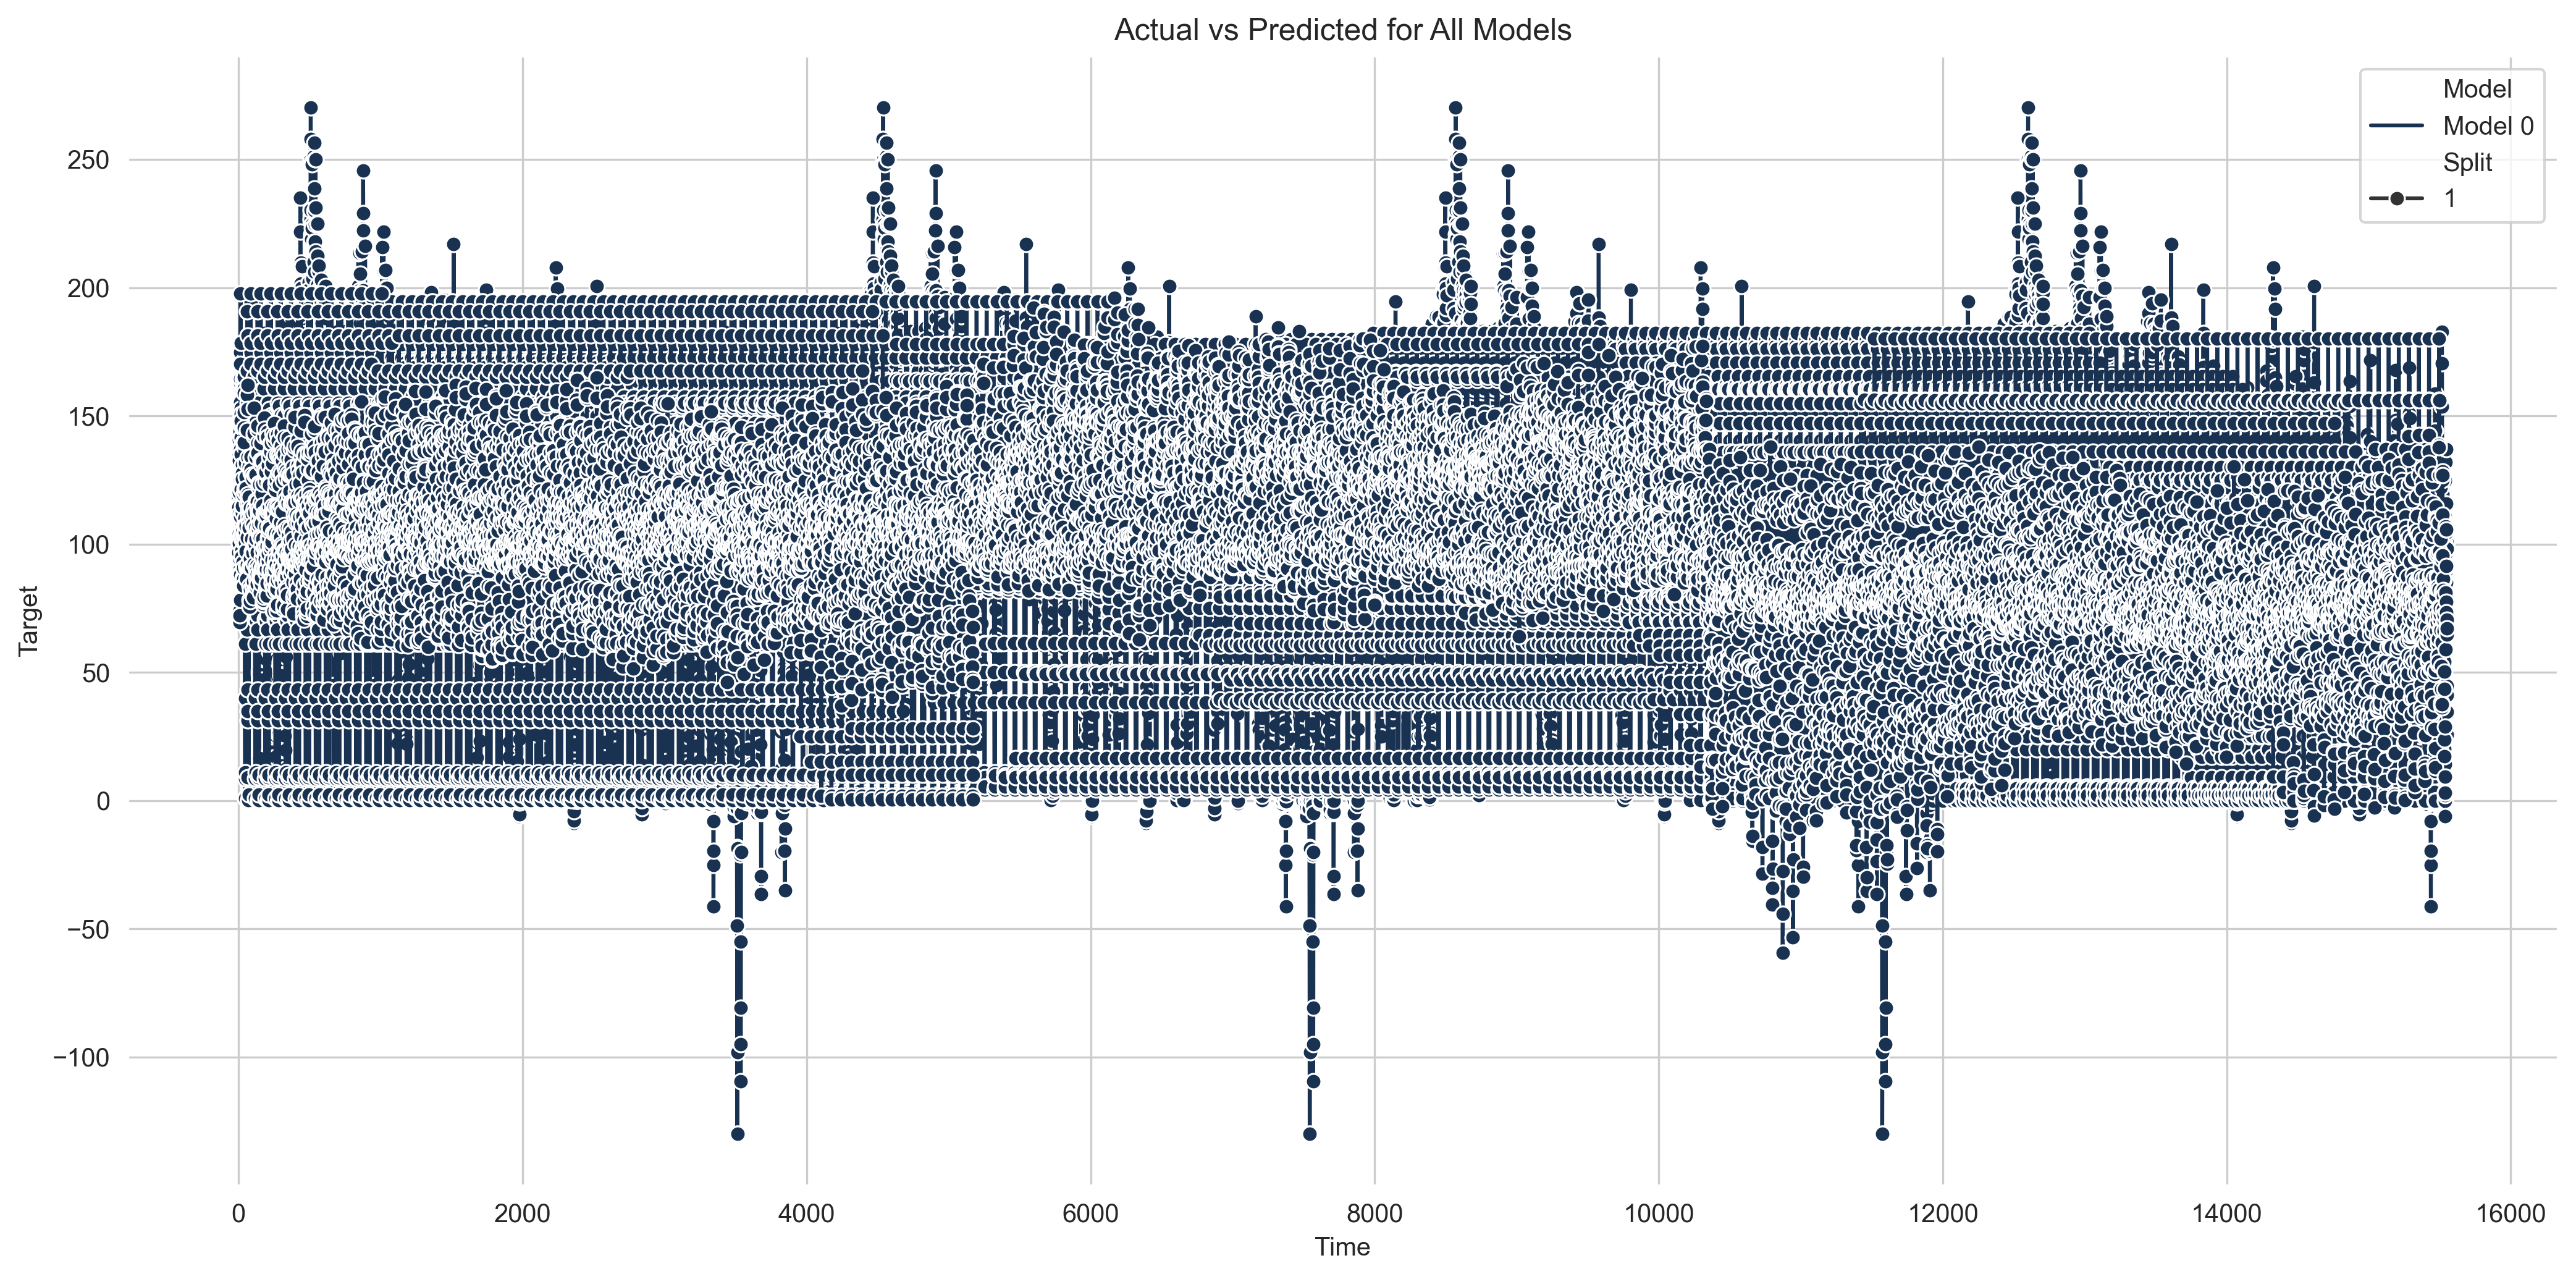

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


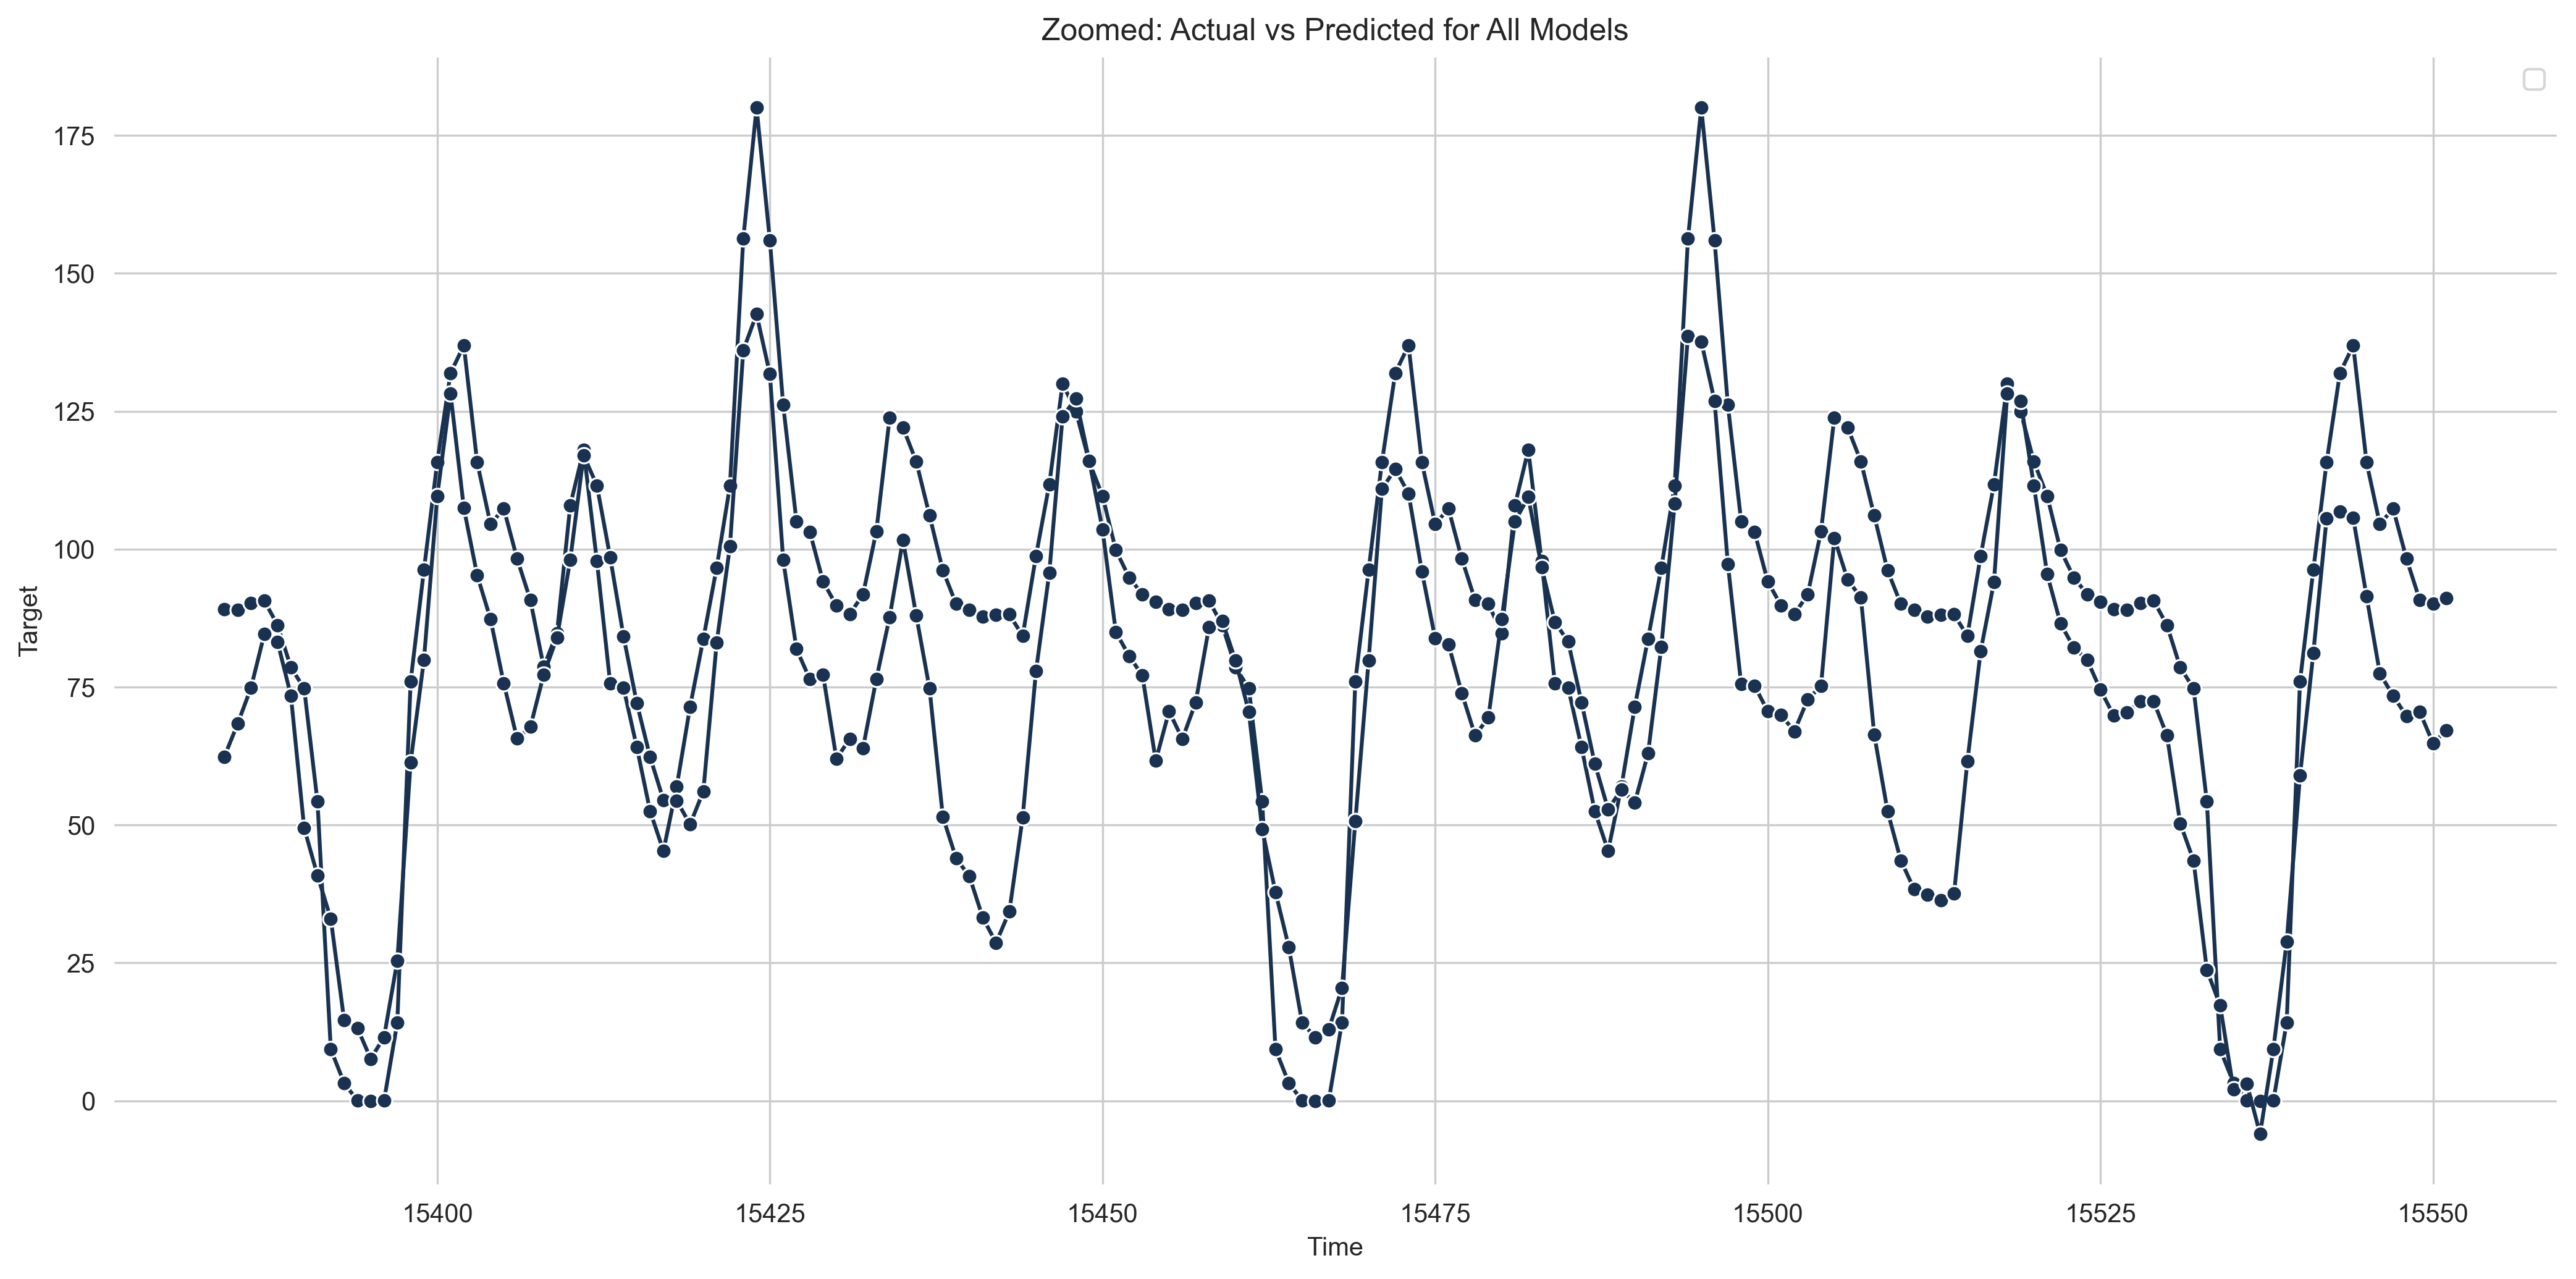

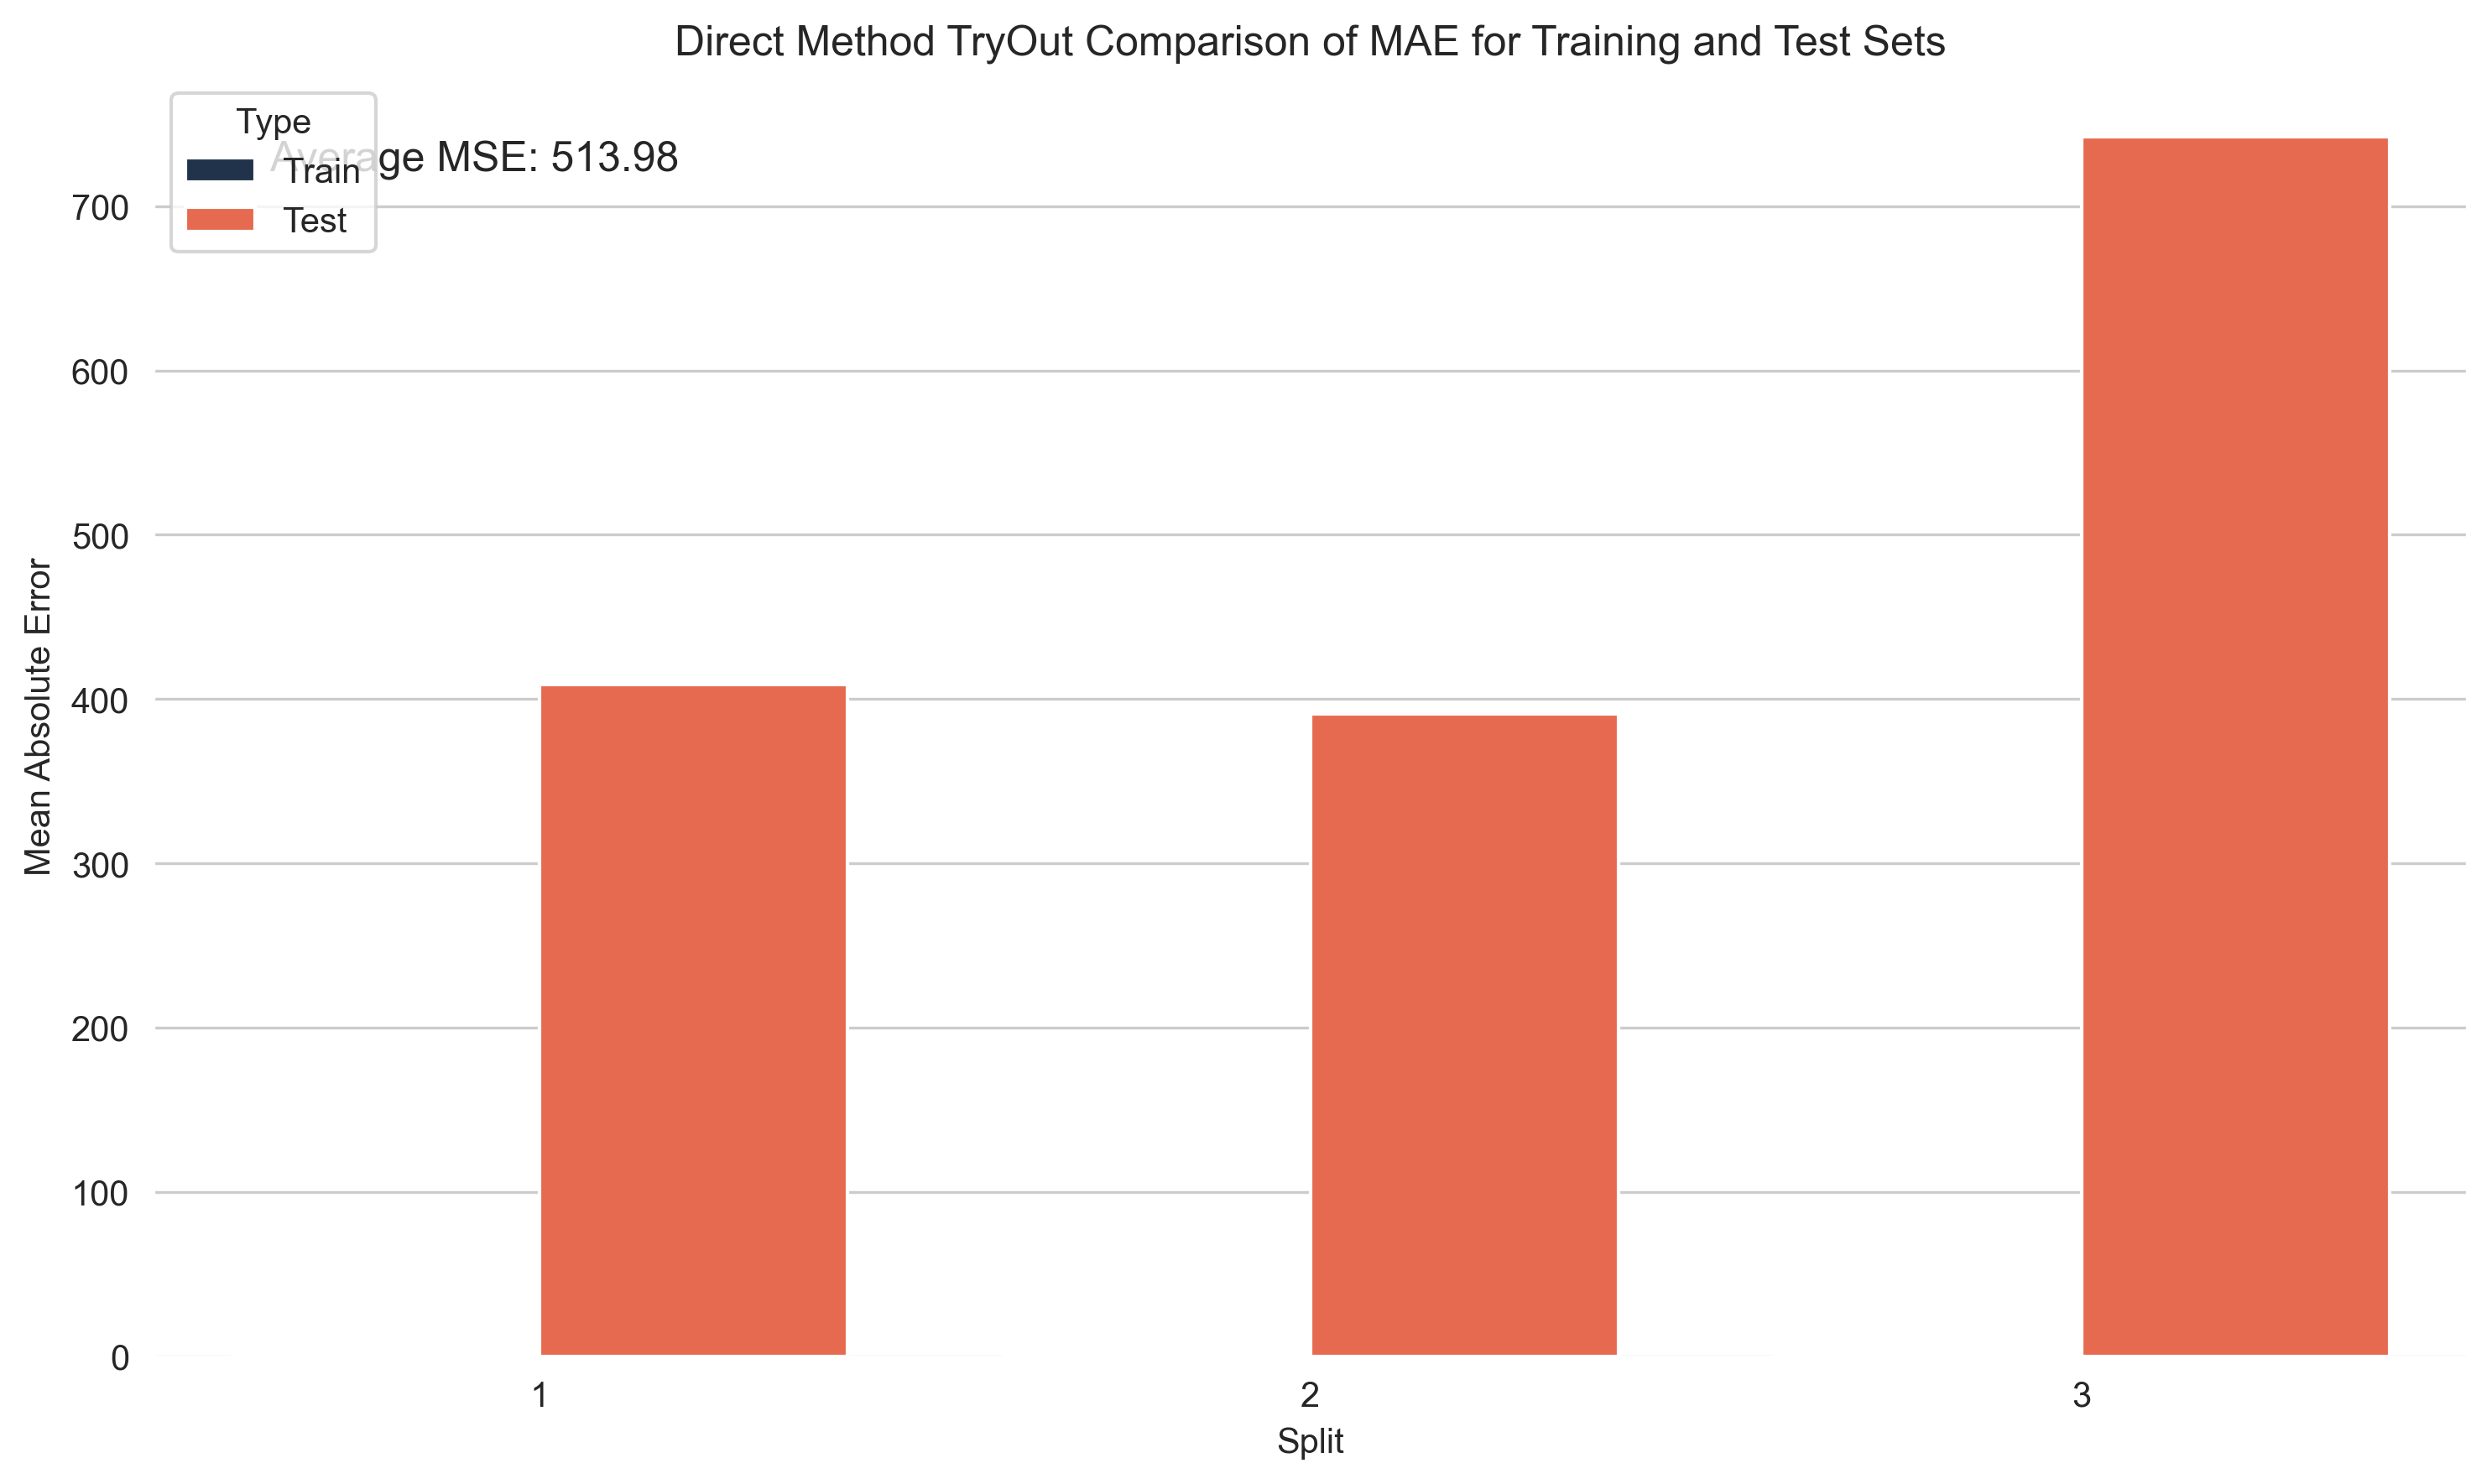

In [26]:
# Assuming plot_data, mae_score_sum, and average_mae are already defined
plot_time_series_combined(plot_data, mse_score_sum, average_mse, model_name='Direct Method TryOut', only_bar=False)

In [21]:
average_mse

513.9776644661089